# Multi-Class Seismic Signal Classification

This notebook classifies 5-second windowed seismic data into three categories: **earthquake**, **traffic**, and **noise** using multiple detection features.

## Classification Strategy

### Signal Types:
- **Earthquakes**: Broadband signals with strong low-frequency content (0.1-2 Hz), high STA/LTA in low-freq band, high kurtosis
- **Traffic/Cars**: Impulsive signals with dominant high-frequency content (8-15 Hz), high STA/LTA in high-freq band
- **Noise**: Background signal with low energy in both bands, low STA/LTA values

### Key Features for Classification:
1. **STA/LTA ratios** in earthquake band (0.1-2 Hz) and traffic band (8-15 Hz)
2. **Kurtosis** - measures impulsiveness/peakiness of signal
3. **Spectral energy** and energy ratios between frequency bands
4. **Spectral centroid** - dominant frequency location
5. **RMS amplitudes** in each frequency band

## Output:
- `windowed_data_array`: numpy array of normalized 5-second waveforms
- `training_metadata`: pandas DataFrame with labels (0=noise, 1=traffic, 2=earthquake) and features

## Import Libraries

Import all necessary libraries for seismic data processing, signal analysis, and classification.

In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

# Scientific computing libraries
from scipy import signal, stats
from scipy.signal import find_peaks, spectrogram
from scipy.ndimage import gaussian_filter1d

# ObsPy imports for seismic data processing

from obspy import UTCDateTime, Stream
from obspy.clients.fdsn import Client
from obspy.signal.trigger import classic_sta_lta
print("ObsPy successfully imported")

# Set up plotting parameters
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")
print("Ready for multi-class signal classification")

ObsPy successfully imported
Libraries imported successfully!
Ready for multi-class signal classification


## Load Seismic Data

Load existing seismic data from the car signal detection notebook or download new data with an earthquake.

In [4]:
# Initialize metadata variables
network = "AM"
station_code = ""  # Will be set after downloading data
channel = "EHZ"

# Define target area - Anchorage, Alaska
urban_areas = {
    "Anchorage, AK": {
        "min_lat": 60.8, "max_lat": 61.6,
        "min_lon": -150.5, "max_lon": -149.3,
        "description": "Urban area with highways and local traffic"
    }
}

# Specific target stations in Anchorage area
target_stations = ['R1796', 'RD369']  # Stations mentioned for car signal analysis

In [5]:
# Option 1: Load data from file (if you saved it from another notebook)
# stream = read("path/to/your/data.mseed")

# Option 2: Download new data with earthquake
client = Client(base_url='https://data.raspberryshake.org')
iris_client = Client("IRIS")


# client = Client(base_url='https://data.raspberryshake.org')
iris_client = Client("IRIS")

# Search for earthquakes in Anchorage region
print("Searching for earthquakes M>=4.0 in Anchorage region...")
catalog = iris_client.get_events(
    starttime=UTCDateTime("2024-01-01"),
    endtime=UTCDateTime("2025-12-10"),
    minlatitude=60,
    maxlatitude=62,
    minlongitude=-151,
    maxlongitude=-149,
    minmagnitude=4.0,
    orderby="magnitude"
)

print(f"Found {len(catalog)} earthquakes")

# Select largest earthquake
selected_event = catalog[0]
origin = selected_event.preferred_origin() or selected_event.origins[0]
magnitude = selected_event.preferred_magnitude() or selected_event.magnitudes[0]
event_time = origin.time

print(f"\nSelected earthquake:")
print(f"  Time: {event_time}")
print(f"  Magnitude: {magnitude.mag:.1f}")
print(f"  Location: {origin.latitude:.3f}°N, {origin.longitude:.3f}°W")

# Set time window: 5 min before to 25 min after
start_time = event_time - 5*60
end_time = event_time + 25*60

# Find station
print("\nSearching for stations...")
inventory = client.get_stations(
    network="AM",
    minlatitude=60.8, maxlatitude=61.6,
    minlongitude=-150.5, maxlongitude=-149.3,
    starttime=start_time, endtime=end_time,
    level="station"
)
print(inventory)

Searching for earthquakes M>=4.0 in Anchorage region...
Found 8 earthquakes

Selected earthquake:
  Time: 2025-11-27T17:11:29.059000Z
  Magnitude: 6.0
  Location: 61.570°N, -150.751°W

Searching for stations...
Inventory created at 2026-01-27T06:48:01.724307Z
	Sending institution: SeisComP (RS)
	Contains:
		Networks (1):
			AM
		Stations (45):
			AM.R0087 (Raspberry Shake Citizen Science Station)
			AM.R032E (Raspberry Shake Citizen Science Station)
			AM.R064A (Raspberry Shake Citizen Science Station)
			AM.R1796 (Raspberry Shake Citizen Science Station)
			AM.R1DCD (Raspberry Shake Citizen Science Station)
			AM.R2252 (Raspberry Shake Citizen Science Station)
			AM.R254E (Raspberry Shake Citizen Science Station)
			AM.R28F8 (Raspberry Shake Citizen Science Station)
			AM.R2A1A (Raspberry Shake Citizen Science Station)
			AM.R3130 (Raspberry Shake Citizen Science Station)
			AM.R3381 (Raspberry Shake Citizen Science Station)
			AM.R4017 (Raspberry Shake Citizen Science Station)
			AM.

In [11]:
# Try each station until we get data
stream = Stream()
for selected_station in inventory[0]:
    station_code = selected_station.code  # Save station code for metadata
    
    # Skip the previously tested station to try a different one
    if station_code == 'R1796':
        print(f"Skipping station: AM.{station_code} (already tested)")
        continue
    
    print(f"\nTrying station: AM.{station_code}")

    # Download data
    print(f"Downloading data from {start_time} to {end_time}...")
    try:
        stream = client.get_waveforms(
            network="AM",
            station=station_code,
            location="00",
            channel="EH*",  # Use vertical component only
            starttime=start_time,
            endtime=end_time
        )
        print(f"✓ Downloaded {len(stream)} traces")
        
        # Preprocess
        stream.detrend('linear')
        stream.detrend('demean')
        stream.taper(max_percentage=0.05)
        
        for tr in stream:
            print(f"  {tr.id}: {len(tr.data)} samples at {tr.stats.sampling_rate} Hz")
        
        # Success! Break and use this station
        break
        
    except Exception as e:
        print(f"Error downloading waveforms: {e}")
        stream = Stream()
        continue

if len(stream) == 0:
    print("\n⚠️  No data available from any station!")
else:
    print(f"\n✓ Using station: AM.{station_code}")



Trying station: AM.RB38A
Error downloading waveforms: No data available for request.
HTTP Status code: 204
Detailed response of server:



Trying station: AM.R4017
✓ Downloaded 3 traces
  AM.R4017.00.EHE: 180001 samples at 100.0 Hz
  AM.R4017.00.EHN: 180001 samples at 100.0 Hz
  AM.R4017.00.EHZ: 180001 samples at 100.0 Hz

✓ Using station: AM.R4017


## Create Frequency-Filtered Versions

Create filtered versions of the data for earthquake (0.1-2 Hz) and traffic (8-15 Hz) detection.

In [12]:
# Create filtered versions for multi-class classification
print("Creating frequency bands for classification...")

# Earthquake band (broad): Low frequency (0.1-2 Hz) - broadband seismic signals
eq_stream = stream.copy()
eq_stream.filter('bandpass', freqmin=0.1, freqmax=2.0, corners=4)
eq_trace = eq_stream[0]

# Earthquake band (low): Very low frequency (0.5-1.5 Hz) - core earthquake energy
eq_low_stream = stream.copy()
eq_low_stream.filter('bandpass', freqmin=0.5, freqmax=1.5, corners=4)
eq_low_trace = eq_low_stream[0]

# Traffic band: High frequency (8-15 Hz) - vehicle-induced vibrations
traffic_stream = stream.copy()
traffic_stream.filter('bandpass', freqmin=8.0, freqmax=15.0, corners=4)
traffic_trace = traffic_stream[0]

# Raw trace for reference
raw_trace = stream[0]
sampling_rate = raw_trace.stats.sampling_rate


print(f"✓ Earthquake band (broad: 0.1-2 Hz) filtered")
print(f"  Duration: {raw_trace.stats.endtime - raw_trace.stats.starttime:.1f} seconds")

print(f"✓ Earthquake band (low: 0.5-1.5 Hz) filtered")
print(f"  Sampling rate: {sampling_rate} Hz")

print(f"✓ Traffic band (8-15 Hz) filtered")
print(f"✓ Raw data prepared")

Creating frequency bands for classification...
✓ Earthquake band (broad: 0.1-2 Hz) filtered
  Duration: 1800.0 seconds
✓ Earthquake band (low: 0.5-1.5 Hz) filtered
  Sampling rate: 100.0 Hz
✓ Traffic band (8-15 Hz) filtered
✓ Raw data prepared


## Compute STA/LTA for Each Frequency Band

Calculate STA/LTA characteristic functions for raw data, earthquake band, and traffic band.

Computing STA/LTA characteristic functions...
✓ STA/LTA computed for raw data
✓ STA/LTA computed for earthquake band (broad: 0.1-2 Hz)
✓ STA/LTA computed for earthquake band (low: 0.5-1.5 Hz)
✓ STA/LTA computed for traffic band (8-15 Hz)
  STA window: 1.0 seconds (100 samples)
  LTA window: 20.0 seconds (2000 samples)
✓ STA/LTA visualization complete
✓ STA/LTA visualization complete


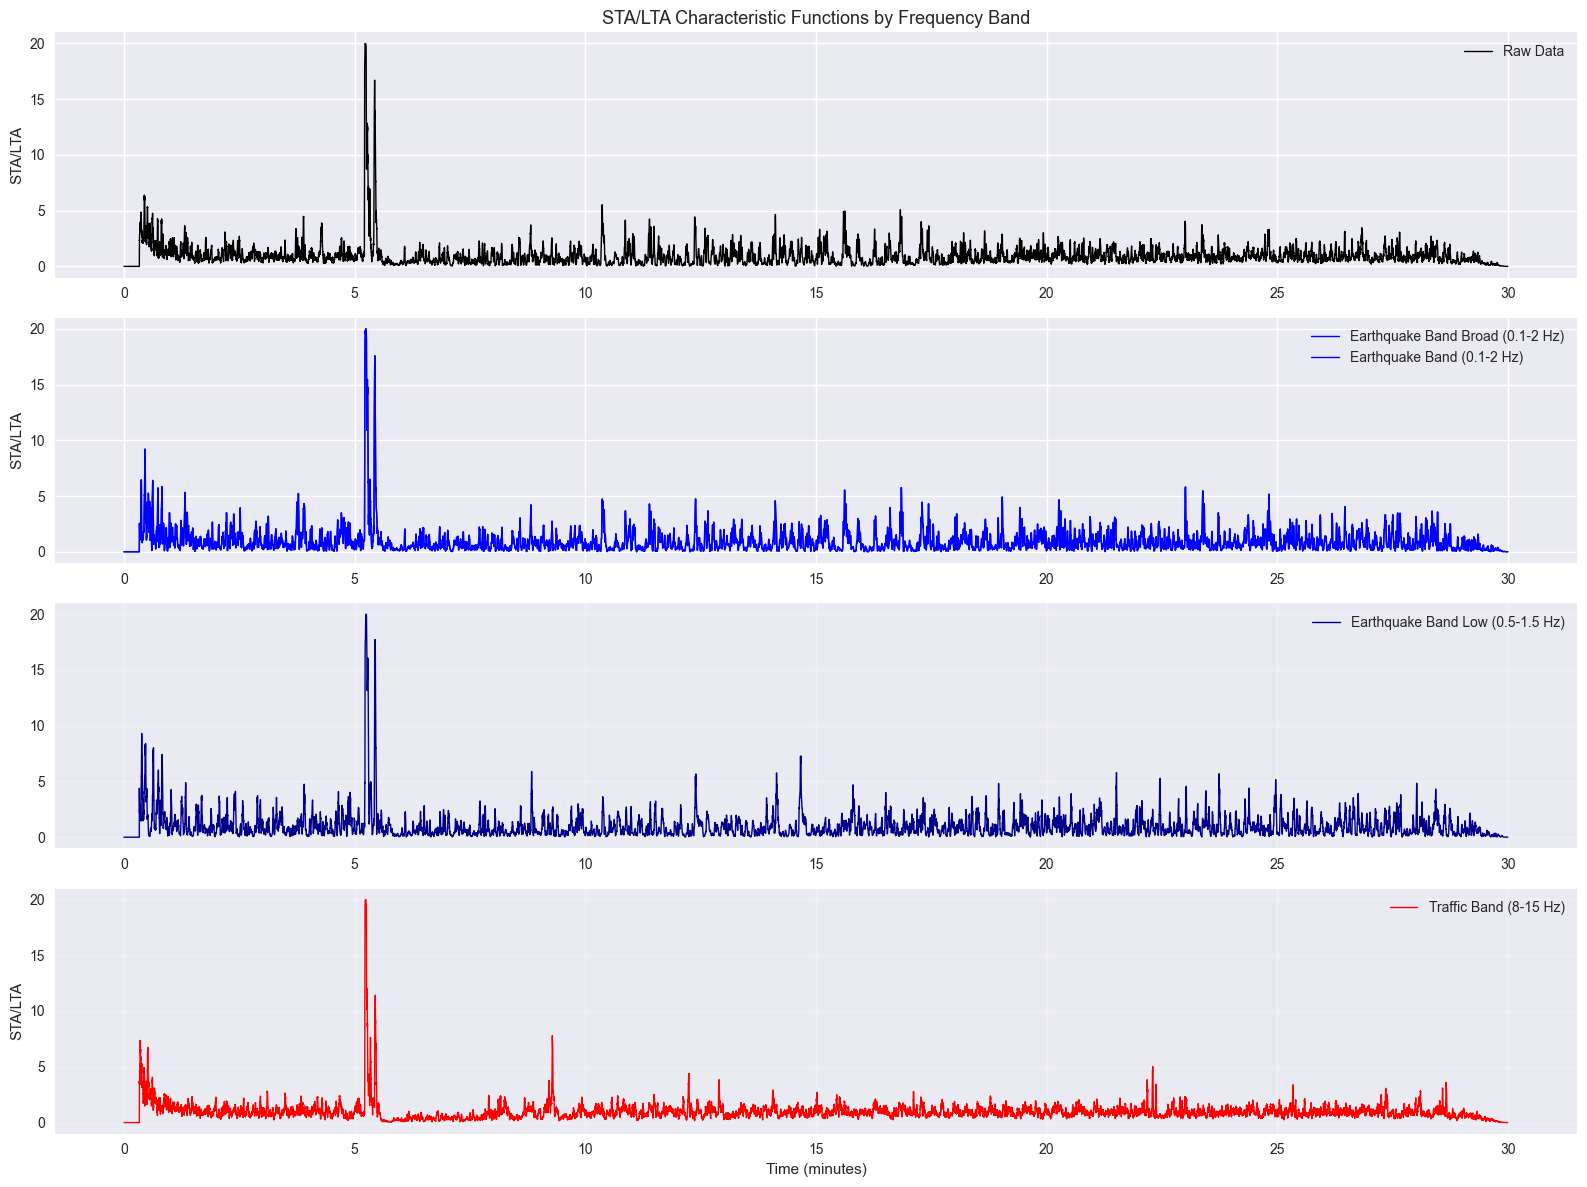

In [8]:
# Compute STA/LTA characteristic functions for each frequency band
print("Computing STA/LTA characteristic functions...")

# STA/LTA parameters
sta_window = 1.0  # 1 second short-term average
lta_window = 20.0  # 10 seconds long-term average

sta_samples = int(sta_window * sampling_rate)
lta_samples = int(lta_window * sampling_rate)

# Compute STA/LTA for each band
cft_raw = classic_sta_lta(raw_trace.data, sta_samples, lta_samples)
cft_eq = classic_sta_lta(eq_trace.data, sta_samples, lta_samples)
cft_eq_low = classic_sta_lta(eq_low_trace.data, sta_samples, lta_samples)
cft_traffic = classic_sta_lta(traffic_trace.data, sta_samples, lta_samples)

print(f"✓ STA/LTA computed for raw data")
print(f"✓ STA/LTA computed for earthquake band (broad: 0.1-2 Hz)")
print(f"✓ STA/LTA computed for earthquake band (low: 0.5-1.5 Hz)")
print(f"✓ STA/LTA computed for traffic band (8-15 Hz)")
print(f"  STA window: {sta_window} seconds ({sta_samples} samples)")
print(f"  LTA window: {lta_window} seconds ({lta_samples} samples)")

# Visualize the STA/LTA functions
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

times_minutes = raw_trace.times() / 60

axes[0].plot(times_minutes, cft_raw, 'k-', linewidth=1, label='Raw Data')
axes[0].set_ylabel('STA/LTA', fontsize=11)
axes[0].set_title('STA/LTA Characteristic Functions by Frequency Band', fontsize=13)
axes[0].legend()
axes[1].plot(times_minutes, cft_eq, 'b-', linewidth=1, label='Earthquake Band Broad (0.1-2 Hz)')

axes[1].plot(times_minutes, cft_eq, 'b-', linewidth=1, label='Earthquake Band (0.1-2 Hz)')
axes[1].set_ylabel('STA/LTA', fontsize=11)
axes[1].legend()
axes[2].plot(times_minutes, cft_eq_low, 'darkblue', linewidth=1, label='Earthquake Band Low (0.5-1.5 Hz)')

axes[2].legend()
axes[2].grid(True, alpha=0.3)

axes[3].plot(times_minutes, cft_traffic, 'r-', linewidth=1, label='Traffic Band (8-15 Hz)')
axes[3].set_ylabel('STA/LTA', fontsize=11)
axes[3].set_xlabel('Time (minutes)', fontsize=11)
axes[3].legend()
axes[3].grid(True, alpha=0.3)


print("✓ STA/LTA visualization complete")

plt.tight_layout()
print("✓ STA/LTA visualization complete")
plt.show()

## Window Data and Extract Comprehensive Features

Create 5-second windows with 50% overlap and extract all classification features including STA/LTA, kurtosis, and spectral energy.

In [9]:
# Windowing parameters
window_length_sec = 5.0  # 5-second windows
window_samples = int(window_length_sec * sampling_rate)
overlap = 0.5  # 50% overlap
step_samples = int(window_samples * (1 - overlap))

print(f"Window configuration:")
print(f"  Window length: {window_length_sec} seconds ({window_samples} samples)")
print(f"  Overlap: {overlap*100:.0f}%")
print(f"  Step size: {step_samples} samples ({step_samples/sampling_rate:.1f} seconds)")

# Calculate number of windows
n_samples = len(raw_trace.data)
n_windows = (n_samples - window_samples) // step_samples + 1

print(f"  Total data samples: {n_samples}")
print(f"  Number of windows: {n_windows}")

# Initialize storage
windowed_data = []
window_features = []

print(f"\nExtracting windows and computing comprehensive features...")

for i in range(n_windows):
    start_idx = i * step_samples
    end_idx = start_idx + window_samples
    
    if end_idx > n_samples:
        break
    
    # Extract windows from each frequency band
    raw_window = raw_trace.data[start_idx:end_idx]
    eq_window = eq_trace.data[start_idx:end_idx]
    eq_low_window = eq_low_trace.data[start_idx:end_idx]
    traffic_window = traffic_trace.data[start_idx:end_idx]
    
    # Extract corresponding STA/LTA windows
    cft_raw_window = cft_raw[start_idx:end_idx]
    cft_eq_window = cft_eq[start_idx:end_idx]
    cft_eq_low_window = cft_eq_low[start_idx:end_idx]
    cft_traffic_window = cft_traffic[start_idx:end_idx]
    
    # Calculate window time
    window_time = raw_trace.stats.starttime + (start_idx / sampling_rate)
    
    # === AMPLITUDE FEATURES ===
    raw_rms = np.sqrt(np.mean(raw_window**2))
    raw_max = np.max(np.abs(raw_window))
    eq_rms = np.sqrt(np.mean(eq_window**2))
    eq_max = np.max(np.abs(eq_window))
    eq_low_rms = np.sqrt(np.mean(eq_low_window**2))
    eq_low_max = np.max(np.abs(eq_low_window))
    traffic_rms = np.sqrt(np.mean(traffic_window**2))
    traffic_max = np.max(np.abs(traffic_window))
    
    # === STA/LTA FEATURES (KEY for classification) ===
    stalta_raw_mean = np.mean(cft_raw_window)
    stalta_raw_max = np.max(cft_raw_window)
    stalta_eq_mean = np.mean(cft_eq_window)
    stalta_eq_max = np.max(cft_eq_window)
    stalta_eq_low_mean = np.mean(cft_eq_low_window)
    stalta_eq_low_max = np.max(cft_eq_low_window)
    stalta_traffic_mean = np.mean(cft_traffic_window)
    stalta_traffic_max = np.max(cft_traffic_window)
    
    # === KURTOSIS FEATURES (KEY for classification) ===
    kurtosis_raw = stats.kurtosis(raw_window)
    kurtosis_eq = stats.kurtosis(eq_window)
    kurtosis_eq_low = stats.kurtosis(eq_low_window)
    kurtosis_traffic = stats.kurtosis(traffic_window)
    
    # === SPECTRAL FEATURES (KEY for classification) ===
    freqs, psd = signal.welch(raw_window, fs=sampling_rate, nperseg=min(256, len(raw_window)//4))
    
    # Energy in low-frequency earthquake band (0.5-1.5 Hz) - CORE earthquake energy
    eq_low_band_idx = (freqs >= 0.5) & (freqs <= 1.5)
    eq_low_band_energy = np.sum(psd[eq_low_band_idx]) if np.any(eq_low_band_idx) else 0
    
    # Energy in broad earthquake band (0.1-2 Hz)
    eq_band_idx = (freqs >= 0.1) & (freqs <= 2.0)
    eq_band_energy = np.sum(psd[eq_band_idx]) if np.any(eq_band_idx) else 0
    
    # Energy in traffic band (8-15 Hz)
    traffic_band_idx = (freqs >= 8.0) & (freqs <= 15.0)
    traffic_band_energy = np.sum(psd[traffic_band_idx]) if np.any(traffic_band_idx) else 0
    
    # Total energy
    total_energy = np.sum(psd)
    
    # Energy ratios
    eq_ratio = eq_band_energy / (total_energy + 1e-10)
    eq_low_ratio = eq_low_band_energy / (total_energy + 1e-10)
    traffic_ratio = traffic_band_energy / (total_energy + 1e-10)
    
    # Low-to-high frequency ratio (earthquake vs traffic discrimination)
    low_to_high_ratio = (eq_low_band_energy + 1e-10) / (traffic_band_energy + 1e-10)
    
    # Spectral centroid and spread
    spectral_centroid = np.sum(freqs * psd) / (np.sum(psd) + 1e-10)
    spectral_spread = np.sqrt(np.sum(((freqs - spectral_centroid)**2) * psd) / (np.sum(psd) + 1e-10))
    
    # === STORE WINDOWED DATA ===
    window_normalized = (raw_window - np.mean(raw_window)) / (np.std(raw_window) + 1e-10)
    windowed_data.append(window_normalized)
    
    # === STORE ALL FEATURES ===
    features = {
        # Window metadata
        'window_id': i,
        'start_time': window_time,
        'start_sample': start_idx,
        'end_sample': end_idx,
        
        # Amplitude features
        'raw_rms': raw_rms,
        'raw_max': raw_max,
        'eq_rms': eq_rms,
        'eq_max': eq_max,
        'eq_low_rms': eq_low_rms,
        'eq_low_max': eq_low_max,
        'traffic_rms': traffic_rms,
        'traffic_max': traffic_max,
        
        # STA/LTA features
        'stalta_raw_mean': stalta_raw_mean,
        'stalta_raw_max': stalta_raw_max,
        'stalta_eq_mean': stalta_eq_mean,
        'stalta_eq_max': stalta_eq_max,
        'stalta_eq_low_mean': stalta_eq_low_mean,
        'stalta_eq_low_max': stalta_eq_low_max,
        'stalta_traffic_mean': stalta_traffic_mean,
        'stalta_traffic_max': stalta_traffic_max,
        
        # Kurtosis features
        'kurtosis_raw': kurtosis_raw,
        'kurtosis_eq': kurtosis_eq,
        'kurtosis_eq_low': kurtosis_eq_low,
        'kurtosis_traffic': kurtosis_traffic,
        
        # Spectral features
        'eq_band_energy': eq_band_energy,
        'eq_low_band_energy': eq_low_band_energy,
        'traffic_band_energy': traffic_band_energy,
        'total_energy': total_energy,
        'eq_ratio': eq_ratio,
        'eq_low_ratio': eq_low_ratio,
        'traffic_ratio': traffic_ratio,
        'low_to_high_ratio': low_to_high_ratio,
        'spectral_centroid': spectral_centroid,
        'spectral_spread': spectral_spread
    }
    
    window_features.append(features)
    
    if (i + 1) % 50 == 0:
        print(f"  Processed {i + 1}/{n_windows} windows...")

# Convert to arrays and DataFrame
windowed_data_array = np.array(windowed_data)
features_df = pd.DataFrame(window_features)

print(f"\n✓ Extracted {len(windowed_data_array)} windows")
print(f"✓ Window data shape: {windowed_data_array.shape}")
print(f"✓ Features dataframe shape: {features_df.shape}")
print(f"✓ Number of features per window: {len(features_df.columns) - 4}")  # Subtract metadata columns

Window configuration:
  Window length: 5.0 seconds (500 samples)
  Overlap: 50%
  Step size: 250 samples (2.5 seconds)
  Total data samples: 180001
  Number of windows: 719

Extracting windows and computing comprehensive features...
  Processed 50/719 windows...
  Processed 100/719 windows...
  Processed 150/719 windows...
  Processed 200/719 windows...
  Processed 250/719 windows...
  Processed 300/719 windows...
  Processed 350/719 windows...
  Processed 400/719 windows...
  Processed 450/719 windows...
  Processed 500/719 windows...
  Processed 550/719 windows...
  Processed 600/719 windows...
  Processed 650/719 windows...
  Processed 700/719 windows...

✓ Extracted 719 windows
✓ Window data shape: (719, 500)
✓ Features dataframe shape: (719, 34)
✓ Number of features per window: 30


## Classification Logic

Apply rule-based classification using the extracted features:

**Classification criteria:**
- **Earthquake (label=2)**: High STA/LTA in earthquake band (0.1-2 Hz), high earthquake energy ratio, high kurtosis indicating impulsive arrivals
- **Traffic (label=1)**: High STA/LTA in traffic band (8-15 Hz), high traffic energy ratio, moderate kurtosis
- **Noise (label=0)**: Low STA/LTA in all bands, distributed energy, low kurtosis

In [10]:
# Define classification thresholds
# These thresholds can be tuned based on your specific data characteristics

# STA/LTA thresholds
EARTHQUAKE_STALTA_LOW_THRESHOLD = 3.0  # Low-freq earthquake band STA/LTA max (stricter)
EARTHQUAKE_STALTA_THRESHOLD = 2.5      # Broad earthquake band STA/LTA max
TRAFFIC_STALTA_THRESHOLD = 2.0         # Traffic band STA/LTA max

# Energy ratio thresholds
EARTHQUAKE_LOW_ENERGY_RATIO = 0.15     # Minimum low-freq (0.5-1.5 Hz) energy ratio
EARTHQUAKE_ENERGY_RATIO = 0.25         # Minimum broad earthquake energy ratio
TRAFFIC_ENERGY_RATIO = 0.15            # Minimum traffic energy ratio

# Low-to-high frequency ratio (earthquakes have much more low-freq energy)
LOW_TO_HIGH_RATIO_THRESHOLD = 5.0      # Low-freq energy / high-freq energy

# Amplitude thresholds (earthquakes are sustained high amplitude)
EARTHQUAKE_RMS_THRESHOLD = 0.0         # Will be set relative to median

# Kurtosis thresholds (earthquakes have lower kurtosis - more sustained)
EARTHQUAKE_KURTOSIS_THRESHOLD = 3.0    # Maximum kurtosis for earthquake (less impulsive than traffic)
TRAFFIC_KURTOSIS_MIN = 0.5             # Minimum kurtosis for traffic (more impulsive)

print("Classification thresholds:")
print(f"  Earthquake STA/LTA low-freq threshold: {EARTHQUAKE_STALTA_LOW_THRESHOLD}")
print(f"  Earthquake STA/LTA broad threshold: {EARTHQUAKE_STALTA_THRESHOLD}")
print(f"  Traffic STA/LTA threshold: {TRAFFIC_STALTA_THRESHOLD}")
print(f"  Earthquake low-freq energy ratio: {EARTHQUAKE_LOW_ENERGY_RATIO}")
print(f"  Earthquake broad energy ratio: {EARTHQUAKE_ENERGY_RATIO}")
print(f"  Traffic energy ratio: {TRAFFIC_ENERGY_RATIO}")
print(f"  Low-to-high frequency ratio: {LOW_TO_HIGH_RATIO_THRESHOLD}")
print(f"  Earthquake max kurtosis: {EARTHQUAKE_KURTOSIS_MAX}")
print(f"  Traffic min kurtosis: {TRAFFIC_KURTOSIS_MIN}")

# Initialize labels
labels = []

# Calculate relative RMS threshold
median_eq_low_rms = features_df['eq_low_rms'].median()
EARTHQUAKE_RMS_THRESHOLD = median_eq_low_rms * 1.5  # 1.5x median

print(f"  Earthquake RMS threshold: {EARTHQUAKE_RMS_THRESHOLD:.6f} (1.5x median)")

print(f"\nClassifying {len(features_df)} windows...")

for idx, row in features_df.iterrows():
    # Extract key features
    stalta_eq_low_max = row['stalta_eq_low_max']
    stalta_eq_max = row['stalta_eq_max']
    stalta_traffic_max = row['stalta_traffic_max']
    eq_low_ratio = row['eq_low_ratio']
    eq_ratio = row['eq_ratio']
    traffic_ratio = row['traffic_ratio']
    low_to_high_ratio = row['low_to_high_ratio']
    eq_low_rms = row['eq_low_rms']
    kurtosis_eq_low = row['kurtosis_eq_low']
    kurtosis_traffic = row['kurtosis_traffic']
    
    # Classification logic
    label = 0  # Default to noise
    
    # Check for earthquake signal - IMPROVED CRITERIA
    # Earthquakes have: high low-freq STA/LTA, high low-freq energy, 
    # low-to-high ratio favoring low freq, sustained amplitude, lower kurtosis
    earthquake_score = 0
    
    if stalta_eq_low_max > EARTHQUAKE_STALTA_LOW_THRESHOLD:
        earthquake_score += 1
    if eq_low_ratio > EARTHQUAKE_LOW_ENERGY_RATIO:
        earthquake_score += 1
    if low_to_high_ratio > LOW_TO_HIGH_RATIO_THRESHOLD:
        earthquake_score += 1
    if eq_low_rms > EARTHQUAKE_RMS_THRESHOLD:
        earthquake_score += 1
    if kurtosis_eq_low < EARTHQUAKE_KURTOSIS_THRESHOLD:  # Less impulsive
        earthquake_score += 1
    
    # Require at least 3 of 5 earthquake criteria
    if earthquake_score >= 3:
        label = 2  # Earthquake
    
    # Check for traffic signal (only if not earthquake)
    elif (stalta_traffic_max > TRAFFIC_STALTA_THRESHOLD and
          traffic_ratio > TRAFFIC_ENERGY_RATIO and
          kurtosis_traffic > TRAFFIC_KURTOSIS_MIN and
          low_to_high_ratio < 2.0):  # Traffic has more balanced or high-freq energy
        label = 1  # Traffic
    
    # Otherwise remains noise (label = 0)
    
    labels.append(label)

# Add labels to features dataframe
features_df['label'] = labels

# Print classification summary
label_counts = features_df['label'].value_counts().sort_index()
print(f"\nClassification results:")
print(f"  Noise (0): {label_counts.get(0, 0)} windows ({label_counts.get(0, 0)/len(labels)*100:.1f}%)")
print(f"  Traffic (1): {label_counts.get(1, 0)} windows ({label_counts.get(1, 0)/len(labels)*100:.1f}%)")
print(f"  Earthquake (2): {label_counts.get(2, 0)} windows ({label_counts.get(2, 0)/len(labels)*100:.1f}%)")
print(f"  Total: {len(labels)} windows")

# Show feature statistics per class
print("\nFeature statistics by class:")
for label_val in sorted(features_df['label'].unique()):
    label_name = ['Noise', 'Traffic', 'Earthquake'][label_val]
    class_df = features_df[features_df['label'] == label_val]
    print(f"\n{label_name} (n={len(class_df)}):")
    print(f"  STA/LTA EQ low max: {class_df['stalta_eq_low_max'].mean():.2f} ± {class_df['stalta_eq_low_max'].std():.2f}")
    print(f"  STA/LTA EQ broad max: {class_df['stalta_eq_max'].mean():.2f} ± {class_df['stalta_eq_max'].std():.2f}")
    print(f"  STA/LTA Traffic max: {class_df['stalta_traffic_max'].mean():.2f} ± {class_df['stalta_traffic_max'].std():.2f}")
    print(f"  EQ low energy ratio: {class_df['eq_low_ratio'].mean():.3f} ± {class_df['eq_low_ratio'].std():.3f}")
    print(f"  EQ broad energy ratio: {class_df['eq_ratio'].mean():.3f} ± {class_df['eq_ratio'].std():.3f}")
    print(f"  Traffic energy ratio: {class_df['traffic_ratio'].mean():.3f} ± {class_df['traffic_ratio'].std():.3f}")
    print(f"  Low-to-high ratio: {class_df['low_to_high_ratio'].mean():.2f} ± {class_df['low_to_high_ratio'].std():.2f}")
    print(f"  Kurtosis EQ low: {class_df['kurtosis_eq_low'].mean():.2f} ± {class_df['kurtosis_eq_low'].std():.2f}")
    print(f"  EQ low RMS: {class_df['eq_low_rms'].mean():.6f} ± {class_df['eq_low_rms'].std():.6f}")

Classification thresholds:
  Earthquake STA/LTA low-freq threshold: 3.0
  Earthquake STA/LTA broad threshold: 2.5
  Traffic STA/LTA threshold: 2.0
  Earthquake low-freq energy ratio: 0.15
  Earthquake broad energy ratio: 0.25
  Traffic energy ratio: 0.15
  Low-to-high frequency ratio: 5.0


NameError: name 'EARTHQUAKE_KURTOSIS_MAX' is not defined

## Visualization

Visualize the classification results and key features to validate the labeling.

In [ ]:
# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))

# Define colors for each class
colors = {0: 'gray', 1: 'orange', 2: 'red'}
labels_text = {0: 'Noise', 1: 'Traffic', 2: 'Earthquake'}

# 1. Timeline with classification labels
ax1 = plt.subplot(6, 1, 1)
times = features_df['start_time'].apply(lambda x: (x - raw_trace.stats.starttime))
for label_val in sorted(features_df['label'].unique()):
    mask = features_df['label'] == label_val
    ax1.scatter(times[mask], np.ones(mask.sum()) * label_val, 
               c=colors[label_val], label=labels_text[label_val], alpha=0.6, s=50)
ax1.set_ylabel('Class')
ax1.set_yticks([0, 1, 2])
ax1.set_yticklabels(['Noise', 'Traffic', 'EQ'])
ax1.set_title('Classification Timeline')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, times.max())

# 2. STA/LTA comparison
ax2 = plt.subplot(6, 1, 2)
for label_val in sorted(features_df['label'].unique()):
    mask = features_df['label'] == label_val
    ax2.scatter(times[mask], features_df.loc[mask, 'stalta_eq_max'], 
               c=colors[label_val], alpha=0.5, s=30, label=f'{labels_text[label_val]} - EQ band')
ax2.axhline(y=EARTHQUAKE_STALTA_THRESHOLD, color='red', linestyle='--', 
           linewidth=1, label=f'EQ threshold ({EARTHQUAKE_STALTA_THRESHOLD})')
ax2.set_ylabel('STA/LTA Max\n(EQ band)')
ax2.legend(loc='upper right', fontsize=8)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, times.max())

ax3 = plt.subplot(6, 1, 3)
for label_val in sorted(features_df['label'].unique()):
    mask = features_df['label'] == label_val
    ax3.scatter(times[mask], features_df.loc[mask, 'stalta_traffic_max'], 
               c=colors[label_val], alpha=0.5, s=30, label=f'{labels_text[label_val]} - Traffic band')
ax3.axhline(y=TRAFFIC_STALTA_THRESHOLD, color='orange', linestyle='--', 
           linewidth=1, label=f'Traffic threshold ({TRAFFIC_STALTA_THRESHOLD})')
ax3.set_ylabel('STA/LTA Max\n(Traffic band)')
ax3.legend(loc='upper right', fontsize=8)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, times.max())

# 3. Kurtosis
ax4 = plt.subplot(6, 1, 4)
for label_val in sorted(features_df['label'].unique()):
    mask = features_df['label'] == label_val
    ax4.scatter(times[mask], features_df.loc[mask, 'kurtosis_eq'], 
               c=colors[label_val], alpha=0.5, s=30, label=labels_text[label_val])
ax4.axhline(y=EARTHQUAKE_KURTOSIS_THRESHOLD, color='red', linestyle='--', 
           linewidth=1, label=f'Impulsive threshold ({EARTHQUAKE_KURTOSIS_THRESHOLD})')
ax4.set_ylabel('Kurtosis\n(EQ band)')
ax4.legend(loc='upper right', fontsize=8)
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, times.max())

# 4. Energy ratios - Earthquake band
ax5 = plt.subplot(6, 1, 5)
for label_val in sorted(features_df['label'].unique()):
    mask = features_df['label'] == label_val
    ax5.scatter(times[mask], features_df.loc[mask, 'eq_ratio'], 
               c=colors[label_val], alpha=0.5, s=30, label=labels_text[label_val])
ax5.axhline(y=EARTHQUAKE_ENERGY_RATIO, color='red', linestyle='--', 
           linewidth=1, label=f'EQ threshold ({EARTHQUAKE_ENERGY_RATIO})')
ax5.set_ylabel('Energy Ratio\n(EQ band)')
ax5.legend(loc='upper right', fontsize=8)
ax5.grid(True, alpha=0.3)
ax5.set_xlim(0, times.max())

# 5. Energy ratios - Traffic band
ax6 = plt.subplot(6, 1, 6)
for label_val in sorted(features_df['label'].unique()):
    mask = features_df['label'] == label_val
    ax6.scatter(times[mask], features_df.loc[mask, 'traffic_ratio'], 
               c=colors[label_val], alpha=0.5, s=30, label=labels_text[label_val])
ax6.axhline(y=TRAFFIC_ENERGY_RATIO, color='orange', linestyle='--', 
           linewidth=1, label=f'Traffic threshold ({TRAFFIC_ENERGY_RATIO})')
ax6.set_ylabel('Energy Ratio\n(Traffic band)')
ax6.set_xlabel('Time (seconds)')
ax6.legend(loc='upper right', fontsize=8)
ax6.grid(True, alpha=0.3)
ax6.set_xlim(0, times.max())

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

In [ ]:
# Display example windows from each class
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for class_idx in range(3):
    class_name = labels_text[class_idx]
    class_windows = features_df[features_df['label'] == class_idx]
    
    if len(class_windows) == 0:
        print(f"Warning: No windows found for class {class_name}")
        continue
    
    # Get up to 3 example windows
    n_examples = min(3, len(class_windows))
    example_indices = class_windows.sample(n=n_examples, random_state=42).index
    
    for i, idx in enumerate(example_indices):
        ax = axes[class_idx, i]
        
        # Get the window data
        window_data = windowed_data_array[idx]
        time_axis = np.arange(len(window_data)) / sampling_rate
        
        # Plot waveform
        ax.plot(time_axis, window_data, color=colors[class_idx], linewidth=1)
        ax.set_title(f'{class_name} - Window {idx}')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Normalized Amplitude')
        ax.grid(True, alpha=0.3)
        
        # Add feature annotations
        row = features_df.loc[idx]
        textstr = f"STA/LTA EQ: {row['stalta_eq_max']:.2f}\n"
        textstr += f"STA/LTA Traffic: {row['stalta_traffic_max']:.2f}\n"
        textstr += f"Kurtosis: {row['kurtosis_eq']:.2f}"
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes, 
               fontsize=8, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("✓ Example windows displayed")

## Save Labeled Dataset

Prepare and save the final dataset for training.

In [ ]:
# Create output directory
output_dir = "labeled_data"
os.makedirs(output_dir, exist_ok=True)

# Generate timestamp for this dataset
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save waveform data
waveforms_file = os.path.join(output_dir, f"windowed_waveforms_{timestamp}.npy")
np.save(waveforms_file, windowed_data_array)
print(f"✓ Saved waveform data to: {waveforms_file}")
print(f"  Shape: {windowed_data_array.shape}")

# Save labels
labels_file = os.path.join(output_dir, f"labels_{timestamp}.npy")
np.save(labels_file, features_df['label'].values)
print(f"✓ Saved labels to: {labels_file}")
print(f"  Shape: {features_df['label'].values.shape}")

# Save full feature metadata
metadata_file = os.path.join(output_dir, f"metadata_{timestamp}.csv")
features_df.to_csv(metadata_file, index=False)
print(f"✓ Saved metadata to: {metadata_file}")
print(f"  Columns: {list(features_df.columns)}")

# Create a summary file
summary_file = os.path.join(output_dir, f"dataset_summary_{timestamp}.txt")
with open(summary_file, 'w') as f:
    f.write("Multi-class Seismic Signal Labeling Summary\n")
    f.write("=" * 60 + "\n\n")
    
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("Data Information:\n")
    f.write(f"  Station: {station_code}\n")
    f.write(f"  Network: {network}\n")
    f.write(f"  Channel: {channel}\n")
    f.write(f"  Sampling rate: {sampling_rate} Hz\n")
    f.write(f"  Start time: {raw_trace.stats.starttime}\n")
    f.write(f"  End time: {raw_trace.stats.endtime}\n")
    f.write(f"  Duration: {(raw_trace.stats.endtime - raw_trace.stats.starttime)/60:.1f} minutes\n\n")
    
    f.write("Windowing Parameters:\n")
    f.write(f"  Window length: {window_length_sec} seconds\n")
    f.write(f"  Overlap: {overlap*100:.0f}%\n")
    f.write(f"  Total windows: {len(windowed_data_array)}\n\n")
    
    f.write("Classification Results:\n")
    for label_val in sorted(features_df['label'].unique()):
        count = (features_df['label'] == label_val).sum()
        percentage = count / len(features_df) * 100
        f.write(f"  {labels_text[label_val]} (label={label_val}): {count} windows ({percentage:.1f}%)\n")
    f.write(f"\n")
    
    f.write("Classification Thresholds Used:\n")
    f.write(f"  Earthquake STA/LTA max: {EARTHQUAKE_STALTA_THRESHOLD}\n")
    f.write(f"  Traffic STA/LTA max: {TRAFFIC_STALTA_THRESHOLD}\n")
    f.write(f"  Earthquake energy ratio: {EARTHQUAKE_ENERGY_RATIO}\n")
    f.write(f"  Traffic energy ratio: {TRAFFIC_ENERGY_RATIO}\n")
    f.write(f"  Earthquake kurtosis: {EARTHQUAKE_KURTOSIS_THRESHOLD}\n\n")
    
    f.write("Files Generated:\n")
    f.write(f"  Waveforms: {waveforms_file}\n")
    f.write(f"  Labels: {labels_file}\n")
    f.write(f"  Metadata: {metadata_file}\n")
    f.write(f"  Summary: {summary_file}\n\n")
    
    f.write("Feature Statistics by Class:\n")
    for label_val in sorted(features_df['label'].unique()):
        class_df = features_df[features_df['label'] == label_val]
        f.write(f"\n  {labels_text[label_val]} (n={len(class_df)}):\n")
        f.write(f"    STA/LTA EQ max: {class_df['stalta_eq_max'].mean():.3f} ± {class_df['stalta_eq_max'].std():.3f}\n")
        f.write(f"    STA/LTA Traffic max: {class_df['stalta_traffic_max'].mean():.3f} ± {class_df['stalta_traffic_max'].std():.3f}\n")
        f.write(f"    EQ energy ratio: {class_df['eq_ratio'].mean():.3f} ± {class_df['eq_ratio'].std():.3f}\n")
        f.write(f"    Traffic energy ratio: {class_df['traffic_ratio'].mean():.3f} ± {class_df['traffic_ratio'].std():.3f}\n")
        f.write(f"    Kurtosis EQ: {class_df['kurtosis_eq'].mean():.3f} ± {class_df['kurtosis_eq'].std():.3f}\n")

print(f"✓ Saved summary to: {summary_file}")

print(f"\n" + "="*60)
print("DATASET CREATION COMPLETE!")
print("="*60)
print(f"\nDataset files saved in: {output_dir}/")
print(f"\nTo load this dataset for training:")
print(f"  X = np.load('{waveforms_file}')")
print(f"  y = np.load('{labels_file}')")
print(f"  metadata = pd.read_csv('{metadata_file}')")